In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib




# Example: Extracellular current stimulation #
This is an example of **``LFPy``** running in an **``IPython notebook``**. To run through this example code and produce output, press **``<shift-Enter>``** in each code block below.

First step is to **import ``LFPy``** and other packages for analysis and plotting:

In [2]:
import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron

## Fetch Hay et al. 2011 model files

In [3]:
if not os.path.isfile('L5bPCmodelsEH/morphologies/cell1.asc'):
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=139653&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('L5bPCmodelsEH.zip', 'r')
    myzip.extractall('.')
    myzip.close()

#compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('L5bPCmodelsEH/mod/')

# Function to calculate external potential from point current source

In [4]:
def make_extracellular_stimuli(dbs_params, cell):
    """ Function to calculate and apply external potential """
    x0, y0, z0 = dbs_params['position']
    sigma = 0.3
    ext_field = np.vectorize(lambda x,y,z: 1 / (4 * np.pi* sigma * np.sqrt((x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2)))
    
    ### MAKING THE EXTERNAL FIELD
    n_tsteps = int(cell.tstop / cell.dt + 1)
    t = np.arange(n_tsteps) * cell.dt
    pulse = np.zeros(n_tsteps)
    start_time = dbs_params['start_time']
    end_time = dbs_params['end_time']
    start_idx = np.argmin(np.abs(t - start_time))
    end_idx = np.argmin(np.abs(t - end_time))
    pulse[start_idx:end_idx] = dbs_params['amp'] * 1000.

    v_cell_ext = np.zeros((cell.totnsegs, n_tsteps))
    v_cell_ext[:, :] = ext_field(cell.xmid, cell.ymid, cell.zmid).reshape(cell.totnsegs, 1) * pulse.reshape(1, n_tsteps)
    print(v_cell_ext)
    print(v_cell_ext.shape)
    cell.insert_v_ext(v_cell_ext, t)
    return ext_field, pulse

# Defining plotting function

In [5]:
def plotting_function(dbs_params, cell, ext_field, pulse):
    
    x0, y0, z0 = dbs_params['position']
    amp = dbs_params['amp'] * 1000.
    
    ### PLOTTING THE RESULTS
    cell_plot_idxs = [0,  cell.get_closest_idx(x=-150., y=0, z=750.)]    
    cell_plot_colors = {cell_plot_idxs[idx]: plt.cm.Greens_r(1./(len(cell_plot_idxs) + 1) * idx + 0.1) 
                        for idx in range(len(cell_plot_idxs))}

    #print cell.xmid[cell_plot_idxs[1]], cell.ymid[cell_plot_idxs[1]], cell.zmid[cell_plot_idxs[1    ]]

    # Plotting the morphology
    plt.figure(figsize=(16,9))

    v_field_ext = np.zeros((50, 200))
    xf = np.linspace(np.min(cell.xend), np.max(cell.xend), 50)
    zf = np.linspace(np.min(cell.zend), np.max(cell.zend), 200)
    for xidx, x in enumerate(xf):
        for zidx, z in enumerate(zf):
            v_field_ext[xidx, zidx] = ext_field(x, 0, z) * amp
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(121, aspect='equal', xlabel='x [$\mu m$]', ylabel='z [$\mu m$]', 
                xlim=[-400, 400], xticks=[-400, 0, 400], title='Green dots: Measurement points')
    plt.imshow(v_field_ext.T, extent=[np.min(cell.xend), np.max(cell.xend), np.min(cell.zend), np.max(cell.zend)], 
               origin='lower', interpolation='nearest', cmap=plt.cm.bwr_r, vmin=-150, vmax=150)

    plt.colorbar(label='mV')
    [plt.plot([cell.xstart[idx], cell.xend[idx]], [cell.zstart[idx], cell.zend[idx]], c='gray', zorder=1) 
     for idx in range(cell.totnsegs)]
    [plt.plot(cell.xmid[idx], cell.zmid[idx], 'o', c=cell_plot_colors[idx], ms=12) 
     for idx in cell_plot_idxs]
    
    l, = plt.plot(x0, z0, 'y*', ms=12)
    plt.legend([l], ["point current source"], frameon=False)

    # Plotting the membrane potentials
    plt.subplot(222, title='Membrane potential', xlabel='Time [ms]', ylabel='mV', ylim=[-80, 20])
    [plt.plot(cell.tvec, cell.vmem[idx, :], c=cell_plot_colors[idx], lw=2) for idx in cell_plot_idxs]

    # Plotting the input currents
    ax1 = plt.subplot(224, ylim=[-2*np.max(np.abs(pulse / 1000)), 2*np.max(np.abs(pulse / 1000))], 
                      ylabel='$\mu$A', title='Injected current')
    ax1.plot(cell.tvec, pulse / 1000)

    #plt.show()


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(642, 1921)


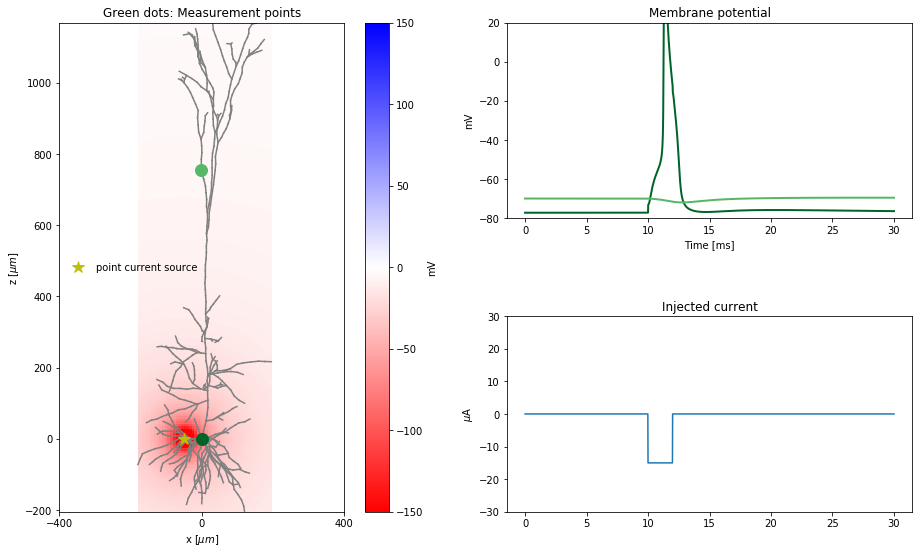

In [6]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-6,
    'tstart' : -159,
    'tstop' : 30,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
}

# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.TemplateCell(**cellParameters)
cell.set_rotation(x=4.729, y=-3.166)

# The parameters of the extracellular point current source 
dbs_params = {'position': [-50., 0, 0.],
              'amp': -15., # uA,
              'start_time': 10.,
              'end_time': 12.,
              }

ext_field, pulse = make_extracellular_stimuli(dbs_params, cell)

cell.simulate(rec_vmem=True)

plotting_function(dbs_params, cell, ext_field, pulse)

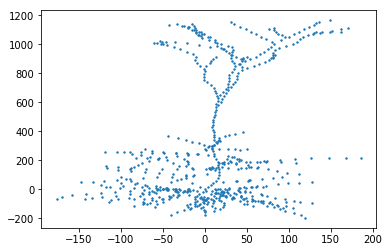

In [7]:
plt.scatter(cell.xmid, cell.zmid,s=2)

In [8]:
cell.insert_v_ext(v_cell_ext, t)
cell.vmem.shape

NameError: name 'v_cell_ext' is not defined

In [ ]:
generator_cell = LFPy.TemplateCell(**cellParameters)
generator_cell.set_rotation(x=4.729, y=-3.166)

receptor_cell = LFPy.TemplateCell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
# Let's put electrodes at each segment of the second cell
electrodeParameters = {
    'sigma' : 0.3,          # extracellular conductivity
    'x' : X.flatten(),      # x,y,z-coordinates of contacts
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    'method' : 'soma_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*X.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}
